In [141]:
!conda install -c anaconda scikit-learn --yes # import scikit-learn
!conda install -c conda-forge geocoder --yes
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c anaconda BeautifulSoup4 --yes

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /Users/user/anaconda3

  added / updated specs: 
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cryptography-2.4.1         |   py36ha12b0ac_0         566 KB  anaconda
    libarchive-3.3.3           |       he8b1da1_4         1.5 MB  anaconda
    pycurl-7.43.0.2            |   py36ha12b0ac_0         185 KB
    python-3.6.7               |       haf84260_0        20.5 MB  anaconda
    libssh2-1.8.0              |       ha12b0ac_4         218 KB  anaconda
    lz4-c-1.8.1.2              |       h1de35cc_0         119 KB  anaconda
    krb5-1.16.1                |       hddcf347_7         1.1 MB  anaconda
    zstd-1.3.7                 |       h5bba6e5_0         593 KB  anaconda
    curl-7.30.0                |                2         327 KB  anaconda
    libcurl-7.63.0             |    h051b688_1000 

In [265]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import geocoder # library to get lat/long data

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from lxml import html

print('Modules imported.')

Modules imported.


In [266]:
# Get requests function to scrape Wikipedia
import requests
import lxml.html as LH
from bs4 import BeautifulSoup

print('Soup is ready.')

Soup is ready.


After installing the libraries we need, next we need to fetch the Chicago neighborhood list from Wikipedia and wrangle it into shape with BeautifulSoup.

In [267]:
# Fetch the Wiki data
wiki_link = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'

raw_wiki_page = requests.get(wiki_link) #get raw wiki page on Toronto neighborhoods

sourceCode = raw_wiki_page.content #get string of source code from response

wiki_page_html= html.document_fromstring(sourceCode) #make HTML element object

In [268]:
soup = BeautifulSoup(sourceCode, 'html.parser')

In [269]:
# Parse the HTML data into a list
neighborhood_names = []
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    neighborhood_names.append([ele for ele in cols if ele]) # Get rid of empty values

In [270]:
# Remove the first record to allow the transformation with the right dimensions
neighborhood_names.remove([])
print(neighborhood_names)

[['Albany Park', 'Albany Park'], ['Altgeld Gardens', 'Riverdale'], ['Andersonville', 'Edgewater'], ['Archer Heights', 'Archer Heights'], ['Armour Square', 'Armour Square'], ['Ashburn', 'Ashburn'], ['Ashburn Estates', 'Ashburn'], ['Auburn Gresham', 'Auburn Gresham'], ['Avalon Park', 'Avalon Park'], ['Avondale', 'Avondale'], ['Avondale Gardens', 'Irving Park'], ['Back of the Yards', 'New City'], ['Belmont Central', 'Belmont Cragin'], ['Belmont Gardens', 'Hermosa'], ['Belmont Heights', 'Dunning'], ['Belmont Terrace', 'Dunning'], ['Beverly', 'Beverly'], ['Beverly View', 'Ashburn'], ['Beverly Woods', 'Morgan Park'], ['Big Oaks', 'Norwood Park'], ['Boystown', 'Lake View'], ['Bowmanville', 'Lincoln Square'], ['Brainerd', 'Washington Heights'], ['Brickyard', 'Belmont Cragin'], ['Bridgeport', 'Bridgeport'], ['Brighton Park', 'Brighton Park'], ['Bronzeville', 'Douglas'], ['Bucktown', 'Logan Square'], ['Budlong Woods', 'Lincoln Square'], ['Buena Park', 'Uptown'], ['Burnside', 'Burnside'], ['Cabri

In [271]:
np.shape(neighborhood_names) # Checking the shape of the initial list

(246, 2)

In [272]:
# Import the raw list into a Pandas dataframe and drop some bogus neighborhood names.
data = np.array(neighborhood_names)

df_data = pd.DataFrame({'Neighborhood':data[:,0],'Community':data[:,1]})

to_drop = ['Austin, Humboldt Park', 'Avondale, Irving Park', 'Chatham, Roseland', 'Lakeview', 'West Town, Logan Square']
df_data = df_data[~df_data['Community'].isin(to_drop)]

df_neighborhoods = df_data

print(df_neighborhoods.shape)  # Check the shape again to see how many rows we're left with.
df_neighborhoods.head()

(241, 2)


Neighborhood       Community
0      Albany Park     Albany Park
1  Altgeld Gardens       Riverdale
2    Andersonville       Edgewater
3   Archer Heights  Archer Heights
4    Armour Square   Armour Square

Now we need to get the latitudes and longitudes for each area. After looking at the GeoJSON file available for Chicago, I decided to drop the neighborhood column and focus on the community column. Apparently, the GeoJSON file does not go down to the neighborhood level.

In [273]:
# Get geocode information for each Community from Bing.

neighborhoods_latlong=[]
neighborhoods_latlong.clear()

for row in range(len(df_neighborhoods)):
    
    address = df_neighborhoods.iloc[row,1] + ', Chicago, IL'
    
    g = geocoder.bing(address, key='AsrJRSv7r-852AI0pRE0Z63s9wVqAi6DcKAve-akWkY6mGed4O2b9ivSuuEFspIp' )
    data = g.json
    ddata = pd.DataFrame.from_dict(data)
    latitude = ddata.iloc[1,5]
    longitude = ddata.iloc[1,6]
       
    hood = df_neighborhoods.iloc[row,1]
    
    neighborhoods_latlong.append([hood, latitude, longitude])
    
df_neighborhoods_latlong = pd.DataFrame(neighborhoods_latlong, columns = ('Community', 'Latitude', 'Longitude'))
    
print(df_neighborhoods_latlong.shape)
df_neighborhoods_latlong.head()

(241, 3)


Community   Latitude  Longitude
0     Albany Park  41.968094 -87.721542
1       Riverdale  41.660000 -87.610001
2       Edgewater  41.985710 -87.663460
3  Archer Heights  41.811539 -87.725563
4   Armour Square  41.834579 -87.631889

In [274]:
# Change the name to Communities and clean it up a bit

df_chicago_communities = df_neighborhoods_latlong.drop_duplicates(subset=None, inplace=False)
df_chicago_communities = df_chicago_communities.reset_index(drop=True)

print(df_chicago_communities.shape)
df_chicago_communities

(77, 3)


Community   Latitude  Longitude
0              Albany Park  41.968094 -87.721542
1                Riverdale  41.660000 -87.610001
2                Edgewater  41.985710 -87.663460
3           Archer Heights  41.811539 -87.725563
4            Armour Square  41.834579 -87.631889
5                  Ashburn  41.747849 -87.709953
6           Auburn Gresham  41.743191 -87.655037
7              Avalon Park  41.744061 -87.594780
8                 Avondale  41.938580 -87.710983
9              Irving Park  41.953548 -87.735649
10                New City  41.810001 -87.660004
11          Belmont Cragin  41.927460 -87.777344
12                 Hermosa  41.924263 -87.734573
13                 Dunning  41.952740 -87.796509
14                 Beverly  41.715630 -87.672813
15             Morgan Park  41.689964 -87.669930
16            Norwood Park  41.986561 -87.794121
17               Lake View  41.947250 -87.653351
18          Lincoln Square  41.975700 -87.689140
19      Washington Heights  41.717556 -87.648758
20              Bridgeport  41.836426 -87.649185
21           Brighton Park  41.817390 -87.698982
22                 Douglas  41.840851 -87.617203
23            Logan Square  41.923367 -87.702629
24                  Uptown  41.980881 -87.659988
25                Burnside  41.729439 -87.597679
26         Near North Side  41.899960 -87.642204
27         Calumet Heights  41.733360 -87.577423
28         Near South Side  41.853882 -87.627113
29                 Chatham  41.740166 -87.615868
30            Chicago Lawn  41.771908 -87.695747
31                Clearing  41.778946 -87.772850
32                 Pullman  41.692822 -87.605759
33          North Lawndale  41.860001 -87.709999
34      East Garfield Park  41.878502 -87.705521
35               Hyde Park  41.794132 -87.592354
36         Lower West Side  41.852242 -87.671150
37               East Side  41.706478 -87.534851
38               West Town  41.893291 -87.657433
39             Forest Glen  41.983002 -87.750000
40             Edison Park  42.007889 -87.813988
41               Englewood  41.777222 -87.642433
42                Roseland  41.706608 -87.623344
43               West Lawn  41.773151 -87.724449
44             Fuller Park  41.812481 -87.634232
45          Near West Side  41.873009 -87.676132
46               Gage Park  41.793652 -87.695610
47                  Austin  41.890373 -87.757462
48          Garfield Ridge  41.790749 -87.770142
49          Jefferson Park  41.968330 -87.763611
50         Grand Boulevard  41.809311 -87.621422
51  Greater Grand Crossing  41.762058 -87.614578
52               Hegewisch  41.653679 -87.546219
53              North Park  41.982941 -87.719147
54           Humboldt Park  41.902828 -87.705582
55             South Shore  41.761559 -87.572701
56                 Kenwood  41.808926 -87.596184
57            Lincoln Park  41.950001 -87.639999
58          South Lawndale  41.849998 -87.709999
59                The Loop  41.882999 -87.633003
60             Rogers Park  42.009655 -87.670135
61           McKinley Park  41.828571 -87.673378
62               Montclare  41.929020 -87.798470
63         Mount Greenwood  41.691441 -87.708733
64            North Center  41.954109 -87.681419
65              West Ridge  41.999481 -87.692657
66                 Oakland  41.824959 -87.605652
67                  O'Hare  41.966370 -87.848579
68            Portage Park  41.955101 -87.762177
69           South Chicago  41.722610 -87.536247
70           South Deering  41.696590 -87.559509
71         Washington Park  41.794498 -87.615837
72             West Elsdon  41.791401 -87.723412
73          West Englewood  41.777580 -87.667229
74      West Garfield Park  41.877022 -87.730743
75            West Pullman  41.673618 -87.635597
76                Woodlawn  41.780460 -87.601349

In [275]:
# This cell is to export the dataframe for deeper inspection if needed.
# df_chicago_communities.to_csv(r'chicago_communities.csv', index=False)

In [276]:
# Create map of Chicago using latitude and longitude values just for fun and to make sure we got the right geo data.

# Chicago location:
latitude = 41.8842506408691
longitude = -87.6324462890625


neighborhoods = df_chicago_communities
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, community in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Community']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

Now we need to get the Foursquare data. We are going to use the Search endpoint with intent=browse in order to grab the most venues available. I also created a file listing the population and area in square meters of each community offline, and calculated the average "radius" from the midpoint at about 1,600 meters. So we're going to use a radius parameter of 2,000 meters in the API to grab as many venues as practical.

In [277]:
# Get Foursquare credentials

CLIENT_ID = 'DTLQASMVMMS0MQIAPDBGXP2JK3NVAOLOBFNJYWXYYZVEISHH' # your Foursquare ID
CLIENT_SECRET = 'FZ14MFTMLS405PUNLR0OUEKKW3W4OSS20MGOYO2QG1MC4NN0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DTLQASMVMMS0MQIAPDBGXP2JK3NVAOLOBFNJYWXYYZVEISHH
CLIENT_SECRET:FZ14MFTMLS405PUNLR0OUEKKW3W4OSS20MGOYO2QG1MC4NN0


In [278]:
# Use FS Search API to get venues for top 5000 venues within 2000 meters of each neighborhood

Radius = 2000
LIMIT = 10000

# Create getNearbyVenues function

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            Radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        
        for v in results:
            vname = v['name']
            vid = v['id']
            vlat = v['location']['lat']
            vlong = v['location']['lng']
            
            if v['categories'] == []:
                vcat = 'NaN'
                vcat_id = 'NaN'
            else: 
                vcat = v['categories'][0]['name']
                vcat_id = v['categories'][0]['id']
            
            venues_list.append([name, lat, lng, vname, vid, vlat, vlong, vcat, vcat_id])
    
    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category',
                  'Venue Category ID']
    
    return(nearby_venues)

In [279]:
# Get the venues for each Community.

df_chicago_venues = getNearbyVenues(names=df_chicago_communities['Community'],
                                   latitudes=df_chicago_communities['Latitude'],
                                   longitudes=df_chicago_communities['Longitude'])

In [280]:
print(df_chicago_venues.shape) # Checking the dimensions of the new venues dataframe.
df_chicago_venues.head()

(9743, 9)


Community  Community Latitude  Community Longitude  \
0  Albany Park           41.968094           -87.721542   
1  Albany Park           41.968094           -87.721542   
2  Albany Park           41.968094           -87.721542   
3  Albany Park           41.968094           -87.721542   
4  Albany Park           41.968094           -87.721542   

                       Venue                  Venue ID  Venue Latitude  \
0          Lawrence Eye Care  4c1d140c8b3aa59340f2995f       41.968289   
1          El Gallo Bravo #6  4b7caf4bf964a5201da12fe3       41.968324   
2   Cuenca's Family Hair Cut  4f579454e4b084174b87bbb3       41.968330   
3  Gallo El Bravo Number Six  4f32606c19836c91c7d1c221       41.968413   
4    Chicago Canvas & Supply  4c4f2ee051c2c928fb81919f       41.968304   

   Venue Longitude      Venue Category         Venue Category ID  
0       -87.721245   Accessories Store  4bf58dd8d48988d102951735  
1       -87.721338  Mexican Restaurant  4bf58dd8d48988d1c1941735  
2       -87.722832  Salon / Barbershop  4bf58dd8d48988d110951735  
3       -87.721364                Food  4d4b7105d754a06374d81259  
4       -87.721737            Building  4bf58dd8d48988d130941735

In [281]:
df_chicago_venues=df_chicago_venues.drop_duplicates().reset_index(drop=True)
print(df_chicago_venues.shape)
df_chicago_venues.head()

(9743, 9)


Community  Community Latitude  Community Longitude  \
0  Albany Park           41.968094           -87.721542   
1  Albany Park           41.968094           -87.721542   
2  Albany Park           41.968094           -87.721542   
3  Albany Park           41.968094           -87.721542   
4  Albany Park           41.968094           -87.721542   

                       Venue                  Venue ID  Venue Latitude  \
0          Lawrence Eye Care  4c1d140c8b3aa59340f2995f       41.968289   
1          El Gallo Bravo #6  4b7caf4bf964a5201da12fe3       41.968324   
2   Cuenca's Family Hair Cut  4f579454e4b084174b87bbb3       41.968330   
3  Gallo El Bravo Number Six  4f32606c19836c91c7d1c221       41.968413   
4    Chicago Canvas & Supply  4c4f2ee051c2c928fb81919f       41.968304   

   Venue Longitude      Venue Category         Venue Category ID  
0       -87.721245   Accessories Store  4bf58dd8d48988d102951735  
1       -87.721338  Mexican Restaurant  4bf58dd8d48988d1c1941735  
2       -87.722832  Salon / Barbershop  4bf58dd8d48988d110951735  
3       -87.721364                Food  4d4b7105d754a06374d81259  
4       -87.721737            Building  4bf58dd8d48988d130941735

In [282]:
# Again to export the dataframe for deeper inspection if needed.
# df_chicago_venues.to_csv(r'chicago_venues.csv', index=False)

In [283]:
# Grouping by Community to count up the venue categories.

df_chicago_venues.groupby('Community').count()

Community Latitude  Community Longitude  Venue  \
Community                                                                
Albany Park                            116                  116    116   
Archer Heights                         139                  139    139   
Armour Square                          124                  124    124   
Ashburn                                123                  123    123   
Auburn Gresham                         114                  114    114   
Austin                                 123                  123    123   
Avalon Park                            148                  148    148   
Avondale                               118                  118    118   
Belmont Cragin                         139                  139    139   
Beverly                                188                  188    188   
Bridgeport                             179                  179    179   
Brighton Park                          136                  136    136   
Burnside                               160                  160    160   
Calumet Heights                        158                  158    158   
Chatham                                133                  133    133   
Chicago Lawn                           168                  168    168   
Clearing                               126                  126    126   
Douglas                                172                  172    172   
Dunning                                169                  169    169   
East Garfield Park                     159                  159    159   
East Side                              122                  122    122   
Edgewater                              154                  154    154   
Edison Park                            183                  183    183   
Englewood                              135                  135    135   
Forest Glen                            173                  173    173   
Fuller Park                            114                  114    114   
Gage Park                              130                  130    130   
Garfield Ridge                         101                  101    101   
Grand Boulevard                        101                  101    101   
Greater Grand Crossing                 153                  153    153   
Hegewisch                              107                  107    107   
Hermosa                                123                  123    123   
Humboldt Park                          136                  136    136   
Hyde Park                              131                  131    131   
Irving Park                             95                   95     95   
Jefferson Park                         134                  134    134   
Kenwood                                124                  124    124   
Lake View                               88                   88     88   
Lincoln Park                           148                  148    148   
Lincoln Square                          70                   70     70   
Logan Square                           131                  131    131   
Lower West Side                        110                  110    110   
McKinley Park                           94                   94     94   
Montclare                              188                  188    188   
Morgan Park                             97                   97     97   
Mount Greenwood                        140                  140    140   
Near North Side                         77                   77     77   
Near South Side                        108                  108    108   
Near West Side                         130                  130    130   
New City                               116                  116    116   
North Center                            85                   85     85   
North Lawndale                         148                  148    148   
North Park                  

In [284]:
# Looking to see how many venue categories we have.
print('There are {} uniques categories.'.format(len(df_chicago_venues['Venue Category'].unique())))  

There are 458 uniques categories.


In [285]:
# Separate and sort the category list and dump it into a CSV file

category_list = df_chicago_venues[['Venue Category', 'Venue Category ID']]
category_list = category_list.sort_values('Venue Category').drop_duplicates(subset=None, inplace=False)
category_list = category_list.reset_index(drop=True)

category_list.head()

# To export the dataframe for deeper inspection if needed.
#df_chicago_venues.to_csv(r'chicago_venues.csv', index=False)

Venue Category         Venue Category ID
0                     ATM  52f2ab2ebcbc57f1066b8b56
1       Accessories Store  4bf58dd8d48988d102951735
2           Acupuncturist  52e81612bcbc57f1066b7a3b
3          Adult Boutique  5267e446e4b0ec79466e48c4
4  Adult Education Center  56aa371ce4b08b9a8d573570

Here we can choose a business type (venue category in FS terms) to search for to see where the opportunities might be for opening up a new location with minimal competition.

We can specify a business type in the input boxes below by using the Foursquare category code and category name (plural). A couple suggestions might be 

'Dentists', code '4bf58dd8d48988d178941735' or 
'Coffee Shops', code '4bf58dd8d48988d1e0931735'

In [286]:
# Define an input variable to focus on one venue category.
user_category_IDcode = input()

4bf58dd8d48988d1e0931735


In [45]:
# Define an input variable for the name of the chosen venue category.
user_category_name = input()

Coffee Shops


Now that we've chosen a busines type to investigate, we go back to Foursquare to pull down all the potential competitors within that venue category so we can plot them on a map.

In [287]:
# Use FS Search API to get the competing locations for the chosen venue category in each neighborhood

Radius = 2000
LIMIT = 10000

# Create getNearbyCompetitors function

def getNearbyCompetitors(names, latitudes, longitudes):
    
    comps_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&intent=browse&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            user_category_IDcode,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            Radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        
        for v in results:
            vname = v['name']
            vid = v['id']
            vlat = v['location']['lat']
            vlong = v['location']['lng']
            
            comps_list.append([name, lat, lng, vname, vid, vlat, vlong])
  
    nearby_comps = pd.DataFrame(comps_list)
    nearby_comps.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                   user_category_name, 
                  'Competitor ID',
                  'Competitor Latitude', 
                  'Competitor Longitude']
    
    return(nearby_comps)

In [288]:
# Get the competitors for each Community.

df_chicago_comps = getNearbyCompetitors(names=df_chicago_communities['Community'],
                                   latitudes=df_chicago_communities['Latitude'],
                                   longitudes=df_chicago_communities['Longitude']
                                  )

In [289]:
print(df_chicago_comps.shape) # Checking the dimensions of the new venues dataframe.
df_chicago_comps.head()

(1113, 7)


Community  Community Latitude  Community Longitude    Coffee Shops  \
0  Albany Park           41.968094           -87.721542       Starbucks   
1  Albany Park           41.968094           -87.721542       Nighthawk   
2  Albany Park           41.968094           -87.721542  Backlot Coffee   
3  Albany Park           41.968094           -87.721542       Starbucks   
4  Albany Park           41.968094           -87.721542  Café Descartes   

              Competitor ID  Competitor Latitude  Competitor Longitude  
0  4b1bdfabf964a5206efe23e3            41.964527            -87.708840  
1  579964a8cd10bd6545689b88            41.967974            -87.713415  
2  5992ee341c675b5afdb4b94c            41.953261            -87.731976  
3  4b5afeaaf964a520e7dd28e3            41.968911            -87.728817  
4  4c4082e6cc410f4794b4a961            41.981552            -87.718156

In [290]:
# Use FS Likes API to get the number of "likes" for each competitor, if any.

# Create getLikes function

def getLikes(cnames, comp_ids):
    
    likes_list=[]
    for cname, comp_id in zip(cnames, comp_ids):
        #print(cname)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(
            comp_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]['likes']
        
        likes_count = results['count']
            
        likes_list.append([cname, comp_id, likes_count])
  
    df_likes_list = pd.DataFrame(likes_list)
    df_likes_list.columns = [user_category_name, 'Competitor ID', 'Likes Count']
    
    return(df_likes_list)

In [291]:
# Get the likes count for each competitor.

df_comp_likes = getLikes(cnames=df_chicago_comps[user_category_name], comp_ids=df_chicago_comps['Competitor ID'])
df_comp_likes.head()

Coffee Shops             Competitor ID  Likes Count
0       Starbucks  4b1bdfabf964a5206efe23e3           58
1       Nighthawk  579964a8cd10bd6545689b88           19
2  Backlot Coffee  5992ee341c675b5afdb4b94c           15
3       Starbucks  4b5afeaaf964a520e7dd28e3           49
4  Café Descartes  4c4082e6cc410f4794b4a961            5

In [292]:
# Taking a look at the "like" situation. We would use these figures to filter out the competitors with no
# likes or those below the average or below the median depending on the situation.

mean_likes = int(df_comp_likes["Likes Count"].mean())
median_likes = int(df_comp_likes["Likes Count"].median())
count_liked = len(df_chicago_comps_liked[(df_chicago_comps_liked['Likes Count'] > 0)])

print(df_comp_likes.shape)
print("The average number of likes is: " + str(mean_likes))
print("The median number of likes is: " + str(median_likes))
print("The number of competitors with any likes is: " + 
      str(count_liked) + 
      " out of " + str(len(df_chicago_comps)) + " " + user_category_name + " in total.")

# Merge the competitor list with the likes list to get it all in one dataframe.

df_chicago_comps_liked = pd.merge(df_chicago_comps,
                 df_comp_likes[['Competitor ID','Likes Count']],
                 on='Competitor ID', 
                 how='left')

df_chicago_comps_liked=df_chicago_comps_liked.drop_duplicates().reset_index(drop=True)

df_chicago_comps_liked.head()

(1113, 3)
The average number of likes is: 36
The median number of likes is: 10
The number of competitors with any likes is: 855 out of 1113 Coffee Shops in total.


Community  Community Latitude  Community Longitude    Coffee Shops  \
0  Albany Park           41.968094           -87.721542       Starbucks   
1  Albany Park           41.968094           -87.721542       Nighthawk   
2  Albany Park           41.968094           -87.721542  Backlot Coffee   
3  Albany Park           41.968094           -87.721542       Starbucks   
4  Albany Park           41.968094           -87.721542  Café Descartes   

              Competitor ID  Competitor Latitude  Competitor Longitude  \
0  4b1bdfabf964a5206efe23e3            41.964527            -87.708840   
1  579964a8cd10bd6545689b88            41.967974            -87.713415   
2  5992ee341c675b5afdb4b94c            41.953261            -87.731976   
3  4b5afeaaf964a520e7dd28e3            41.968911            -87.728817   
4  4c4082e6cc410f4794b4a961            41.981552            -87.718156   

   Likes Count  
0           58  
1           19  
2           15  
3           49  
4            5

In [293]:
# Here we filter out the "unliked" or "less liked" competitors.

df_chicago_comps_filtered = df_chicago_comps_liked[(df_chicago_comps_liked['Likes Count'] > 0)]
print(df_chicago_comps_filtered.shape)
df_chicago_comps_filtered.head()

(855, 8)


Community  Community Latitude  Community Longitude    Coffee Shops  \
0  Albany Park           41.968094           -87.721542       Starbucks   
1  Albany Park           41.968094           -87.721542       Nighthawk   
2  Albany Park           41.968094           -87.721542  Backlot Coffee   
3  Albany Park           41.968094           -87.721542       Starbucks   
4  Albany Park           41.968094           -87.721542  Café Descartes   

              Competitor ID  Competitor Latitude  Competitor Longitude  \
0  4b1bdfabf964a5206efe23e3            41.964527            -87.708840   
1  579964a8cd10bd6545689b88            41.967974            -87.713415   
2  5992ee341c675b5afdb4b94c            41.953261            -87.731976   
3  4b5afeaaf964a520e7dd28e3            41.968911            -87.728817   
4  4c4082e6cc410f4794b4a961            41.981552            -87.718156   

   Likes Count  
0           58  
1           19  
2           15  
3           49  
4            5

In [294]:
# Group the list by community to show the filtered number of competitors in each community

df_comps_grouped = df_chicago_comps_filtered.groupby(['Community'], as_index=False).count()
df_comps_grouped = df_comps_grouped[['Community',user_category_name]]
print(df_comps_grouped.shape)
df_comps_grouped.head()

(73, 2)


Community  Coffee Shops
0     Albany Park            22
1  Archer Heights             7
2   Armour Square            10
3         Ashburn             5
4  Auburn Gresham             1

In [295]:
# Load the CSV file for Chicago community stats - population and area

data = pd.read_csv('chicago_community_stats.csv')
chicago_community_stats = pd.DataFrame(data)
print(chicago_community_stats.shape)
chicago_community_stats.head()

(77, 4)


Community   Area  Population  Income
0     Albany Park   5.00       52079   51969
1  Archer Heights   5.21       13266   43394
2   Armour Square   2.56       14068   24336
3         Ashburn  12.61       42752   63573
4  Auburn Gresham   9.76       45842   29389

In [296]:
# Merge the two dataframes using a Left Join

df_community_comps = pd.merge(chicago_community_stats, df_comps_grouped, on='Community', how='left')
df_community_comps[user_category_name].fillna(0, inplace=True)  # Fill "NaN" values with zeros
print(df_community_comps.shape)  #Show shape and list to make sure we still have 77 rows
df_community_comps

(77, 5)


Community   Area  Population  Income  Coffee Shops
0              Albany Park   5.00       52079   51969          22.0
1           Archer Heights   5.21       13266   43394           7.0
2            Armour Square   2.56       14068   24336          10.0
3                  Ashburn  12.61       42752   63573           5.0
4           Auburn Gresham   9.76       45842   29389           1.0
5                   Austin  18.54       97643   31634           2.0
6              Avalon Park   7.69        9780   41531           4.0
7                 Avondale   5.18       39721   44663          20.0
8           Belmont Cragin  10.20       79159   43534          10.0
9                  Beverly   8.29       20815   90766           9.0
10              Bridgeport   5.44       33878   43056          11.0
11           Brighton Park   7.04       44202   36077           4.0
12                Burnside   1.61        2601   23632           3.0
13         Calumet Heights   4.58       13732   49923           1.0
14                 Chatham   7.69       31392   32222           6.0
15            Chicago Lawn   9.04       55551   33122           2.0
16                Clearing   6.63       24962   60624           0.0
17                 Douglas   4.33       20323   29185           9.0
18                 Dunning   9.71       43025   59737           8.0
19      East Garfield Park   5.02       20656   21482           4.0
20               East Side   7.25       23784   43421           1.0
21               Edgewater   4.43       54873   46174          26.0
22             Edison Park   3.03       11208   86300          11.0
23               Englewood   8.00       26121   19854           3.0
24             Forest Glen   8.31       18459  101559           7.0
25             Fuller Park   1.84        2543   20093           4.0
26               Gage Park   5.80       41202   38852           6.0
27          Garfield Ridge  10.96       35570   60851           2.0
28         Grand Boulevard   4.48       22373   30260           3.0
29  Greater Grand Crossing   9.22       32346   26515           2.0
30               Hegewisch  12.38        8985   50338           0.0
31                 Hermosa   3.03       25489   39157          11.0
32           Humboldt Park   9.32       55011   68514          12.0
33               Hyde Park   4.27       26893   45335          17.0
34             Irving Park   8.37       56520   51997          22.0
35          Jefferson Park   6.09       27264   60472          12.0
36                 Kenwood   2.82       17601   39158          13.0
37               Lake View   8.18       99876   82254          46.0
38            Lincoln Park   8.26       67260   95416          29.0
39          Lincoln Square   6.66       40761   62934          27.0
40            Logan Square   8.37       73702   59216          29.0
41         Lower West Side   7.25       34410   36090          13.0
42           McKinley Park   3.63       15612   43828           7.0
43               Montclare   2.56       13024   43015           7.0
44             Morgan Park   8.26       22924   60747           5.0
45         Mount Greenwood   7.07       18783   89536           5.0
46         Near North Side   7.04       86343   88651          50.0
47         Near South Side   4.53       22401   78290          16.0
48          Near West Side  14.89       61768   72143          12.0
49                New City  12.59       40997   30421           4.0
50            North Center   5.36       34623   92664          33.0
51          North Lawndale   8.29       35276   22383           4.0
52              North Park   5.36       18442   51818          18.0
53            Norwood Park  11.11       36651   71282           7.0
54                  O'Hare  84.10       13695   46638          11.0
55                 Oakland   1.55        6422   28436           5.0
56            Portage Park  10.31       64841   57031          16.0
57                 Pullman  12.58        6501   36728           3.0
58   

In [297]:
# Add calculations in new columns

df_community_comps[user_category_name + "/SqKM"] = df_community_comps[user_category_name] / df_community_comps["Area"]
df_community_comps[user_category_name + " per Capita"] = df_community_comps[user_category_name] / df_community_comps["Population"]

# Add columns that normalize the last two ratio columns to use in the choropleth map.

df_community_comps['PerSqKM Norm'] = (df_community_comps.iloc[:,5] - df_community_comps.iloc[:,5].min()) / (df_community_comps.iloc[:,5].max() - df_community_comps.iloc[:,5].min())
df_community_comps['PerCap Norm'] = (df_community_comps.iloc[:,6] - df_community_comps.iloc[:,6].min()) / (df_community_comps.iloc[:,6].max() - df_community_comps.iloc[:,6].min())

df_community_comps.sort_values(user_category_name, inplace=True)

print(df_community_comps.shape)  #Show shape and list to make sure we still have 77 rows
df_community_comps

(77, 9)


Community   Area  Population  Income  Coffee Shops  \
16                Clearing   6.63       24962   60624           0.0   
30               Hegewisch  12.38        8985   50338           0.0   
58               Riverdale   8.70        7090   14846           0.0   
62           South Deering  23.03       15305   35056           0.0   
20               East Side   7.25       23784   43421           1.0   
13         Calumet Heights   4.58       13732   49923           1.0   
61           South Chicago   8.65       28095   28504           1.0   
4           Auburn Gresham   9.76       45842   29389           1.0   
5                   Austin  18.54       97643   31634           2.0   
73            West Pullman   9.27       27982   33898           2.0   
29  Greater Grand Crossing   9.22       32346   26515           2.0   
27          Garfield Ridge  10.96       35570   60851           2.0   
15            Chicago Lawn   9.04       55551   33122           2.0   
71      West Garfield Park   3.32       17742   23947           2.0   
28         Grand Boulevard   4.48       22373   30260           3.0   
60                Roseland  12.58       42505   37242           3.0   
23               Englewood   8.00       26121   19854           3.0   
64             South Shore   7.69       51451   26425           3.0   
57                 Pullman  12.58        6501   36728           3.0   
12                Burnside   1.61        2601   23632           3.0   
19      East Garfield Park   5.02       20656   21482           4.0   
6              Avalon Park   7.69        9780   41531           4.0   
72               West Lawn   7.72       32749   50384           4.0   
49                New City  12.59       40997   30421           4.0   
25             Fuller Park   1.84        2543   20093           4.0   
51          North Lawndale   8.29       35276   22383           4.0   
11           Brighton Park   7.04       44202   36077           4.0   
67      Washington Heights   7.43       27116   44071           4.0   
70          West Englewood   8.16       32156   27339           4.0   
63          South Lawndale  11.50       73876   30701           5.0   
44             Morgan Park   8.26       22924   60747           5.0   
45         Mount Greenwood   7.07       18783   89536           5.0   
55                 Oakland   1.55        6422   28436           5.0   
3                  Ashburn  12.61       42752   63573           5.0   
26               Gage Park   5.80       41202   38852           6.0   
14                 Chatham   7.69       31392   32222           6.0   
24             Forest Glen   8.31       18459  101559           7.0   
1           Archer Heights   5.21       13266   43394           7.0   
42           McKinley Park   3.63       15612   43828           7.0   
69             West Elsdon   3.06       19219   44791           7.0   
43               Montclare   2.56       13024   43015           7.0   
53            Norwood Park  11.11       36651   71282           7.0   
18                 Dunning   9.71       43025   59737           8.0   
9                  Beverly   8.29       20815   90766           9.0   
17                 Douglas   4.33       20323   29185           9.0   
8           Belmont Cragin  10.20       79159   43534          10.0   
2            Armour Square   2.56       14068   24336          10.0   
74              West Ridge   9.14       72211   46091          11.0   
31                 Hermosa   3.03       25489   39157          11.0   
10              Bridgeport   5.44       33878   43056          11.0   
68         Washington Park   3.83       12081   22085          11.0   
54                  O'Hare  84.10       13695   46638          11.0   
22             Edison Park   3.03       11208   86300          11.0   
32           Humboldt Park   9.32       55011   68514          12.0   
48          Near West Side  14.89       61768   72143          12.0   
35          Jefferson Park   6.09       2

In [298]:
# Again to export the dataframe for deeper inspection if needed.
#df_community_comps.to_csv(r'community_comps.csv', index=False)

Now we're going to create a couple of choropleth maps. The first one shows the distribution of household income in Chicago. The second map shows which Chicago communities have a lower density of locations for our chosen business type. These would be good potential areas to investigate for opening up a new business location because they should be less competitive.

I chose to base the scale on the density of competitors per capital, normalized, but I included columns for density per square kilometer too in case the user wants to use that metric instead.

If you click on the red markers, you will see the names of each community pop up on your screen. You can use this to drill deeper into the individual competing business located in each community below.

In [299]:
# for the Chloropleth map, import the GeoJSON file

chicago_geo = r'chicago.geojson.json' # geojson file

In [300]:
# generate choropleth map using the median household income for each Chicago community

# Chicago location:
latitude = 41.8842506408691
longitude = -87.6324462890625

neighborhoods = df_chicago_communities
comp_locations = df_community_comps

map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11, prefer_canvas=True, tiles='Mapbox Bright')

map_chicago.choropleth(
    geo_data=chicago_geo,
    data=comp_locations,
    columns=['Community', 'Income'],
    key_on='feature.properties.name',
    fill_color='PuBuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median Household Income by Chicago Community')

# add markers to map so you can see the names of the communities
for lat, lng, community in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Community']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago) 


# Show map
map_chicago

In [301]:
# generate choropleth map using the normalized per capital density of the chosen business category type

# Chicago location:
latitude = 41.8842506408691
longitude = -87.6324462890625

neighborhoods = df_chicago_communities
comp_locations = df_community_comps

map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11, prefer_canvas=True, tiles='Mapbox Bright')

map_chicago.choropleth(
    geo_data=chicago_geo,
    data=comp_locations,
    columns=['Community', 'PerCap Norm'],
    key_on='feature.properties.name',
    fill_color='PuRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Density of ' + user_category_name + ' by Chicago Community')

# add markers to map so you can see the names of the communities
for lat, lng, community in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Community']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago) 


# Show map
map_chicago

Looking at how the denser competitor areas above might be corresponding to the higher income areas, I decided to pull both columns into a Seaborn regression chart below to see what the correlation might look like.

In [302]:
# Create separate dataframe to examine the potential correlation between income
# distribution and venue density per capita.

col_label = str(user_category_name + ' per Capita')
adj_col_label = str('Adj ' + col_label)
df_corr = df_community_comps.filter(['Community', 'Income', col_label], axis=1)
df_corr[adj_col_label] = df_corr[col_label] * 1000000000

df_corr.head(10)



Community  Income  Coffee Shops per Capita  \
16         Clearing   60624                 0.000000   
30        Hegewisch   50338                 0.000000   
58        Riverdale   14846                 0.000000   
62    South Deering   35056                 0.000000   
20        East Side   43421                 0.000042   
13  Calumet Heights   49923                 0.000073   
61    South Chicago   28504                 0.000036   
4    Auburn Gresham   29389                 0.000022   
5            Austin   31634                 0.000020   
73     West Pullman   33898                 0.000071   

    Adj Coffee Shops per Capita  
16                     0.000000  
30                     0.000000  
58                     0.000000  
62                     0.000000  
20                 42045.072318  
13                 72822.604136  
61                 35593.521979  
4                  21814.056978  
5                  20482.779103  
73                 71474.519334

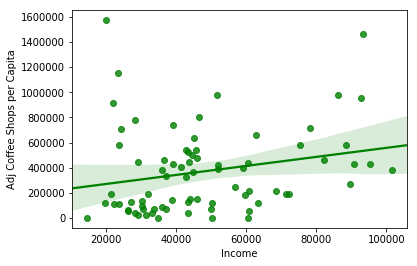

In [303]:
# Plot the data on a Seaborn regression chart. Looks like there might be a slightly positive correlation.
import seaborn as sns
ax = sns.regplot(x='Income', y=adj_col_label, data=df_corr, color='green')

This next map is a "Fast Marker Cluster" map that shows where most of the competing business are located. As you drill into it, the clusters will open up into smaller clusters and into individual location markers in some areas. I wanted to include this capability in the choropleth map above, but Folium will not handle large numbers of markers in combination with other overlays in the same map very easily.

In [304]:
# Generate showing the competitors clustered in markers which open up when you zoom in

from folium import plugins

# Chicago location:
latitude = 41.8842506408691
longitude = -87.6324462890625

neighborhoods = df_chicago_communities
comp_locations = df_chicago_comps_filtered


lats = comp_locations['Competitor Latitude']
longs = comp_locations['Competitor Longitude']
labels = comp_locations[user_category_name]
num_comps = len(comp_locations)

map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10, prefer_canvas=True)

if num_comps < 250:

    # instantiate a mark cluster object for the comps in the dataframe
    competitors = plugins.MarkerCluster().add_to(map_chicago)

    # loop through the dataframe and add each data point to the mark cluster
    for lat, lng, label, in zip(lats, longs, labels):
        folium.Marker(
            location=[lat, lng],
            icon=None,
            popup=label,
        ).add_to(competitors)

else:

    # instantiate a mark cluster object for the individual competitive businesses
    competitors = plugins.FastMarkerCluster(data=list(zip(lats, longs))).add_to(map_chicago)



# Show map
map_chicago

Next, we provide the user with a way to enter the name of a particular neighborhood and get a list of competitors nearby with a 2,000 meter radius.

In [305]:
# Enter the name of a Chicago community to drill in and get a list of competitors there.
community_name = input()

Lincoln Park


In [306]:
df_temp = df_chicago_communities.set_index("Community", drop = False)

local_lat = df_temp.loc[community_name, 'Latitude']
local_long = df_temp.loc[community_name, 'Longitude']

#local_lat = local_lat.iloc[1:1]

print(local_lat, local_long)

41.9500007629395 -87.6399993896484


In [307]:
# Use FS Search API to get the competing locations for the chosen venue category in one particular neighborhood

Radius = 2000
LIMIT = 1000

# create the API request URL

url = 'https://api.foursquare.com/v2/venues/search?&intent=browse&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    user_category_IDcode,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    local_lat, 
    local_long, 
    Radius, 
    LIMIT)
            
# make the GET request

results = requests.get(url).json()["response"]['venues']
        
# return only relevant information for each nearby venue

local_list = []
for v in results:
    vname = v['name']
    vid = v['id']
    
    try: vaddress = v['location']['address']  # filter out venues without an address listed
    except KeyError: pass
        
    try: vzip = v['location']['postalCode']
    except KeyError: vzip = 'NaN'
            
    local_list.append([community_name, vname, vaddress, vzip, vid])
  
df_local_comps = pd.DataFrame(local_list)
df_local_comps.columns = ['Community', user_category_name, 'Address', 'Zip', "Venue ID"]
df_local_comps.sort_values(by='Address', inplace = True)
df_local_comps.reset_index(drop = True, inplace = True)

print(df_local_comps.shape)
df_local_comps

(30, 5)


Community                    Coffee Shops                 Address  \
0   Lincoln Park  Bittersweet Pastry Shop & Cafe      1114 W Belmont Ave   
1   Lincoln Park               Osmium Coffee Bar      1117 W Belmont Ave   
2   Lincoln Park                       Starbucks         2754 N Clark St   
3   Lincoln Park          Stan's Donuts & Coffee         2800 N Clark St   
4   Lincoln Park                 Hero Coffee Bar      2950 N Sheridan Rd   
5   Lincoln Park       Bobtail Ice Cream Company      2951 N Broadway St   
6   Lincoln Park             Peet's Coffee & Tea         3025 Clark St.,   
7   Lincoln Park                       Starbucks        3030 N. Broadway   
8   Lincoln Park           Intelligentsia Coffee      3123 N Broadway St   
9   Lincoln Park                       Starbucks         3184 N Clark St   
10  Lincoln Park               The Alley Chicago         3221 N Clark St   
11  Lincoln Park          Stan's Donuts & Coffee      3300 N Broadway St   
12  Lincoln Park       The Coffee & Tea Exchange      3311 N Broadway St   
13  Lincoln Park                    Yefseis Café       3344 N Halsted St   
14  Lincoln Park                       Starbucks      3358 N Broadway St   
15  Lincoln Park                 Pick Me Up Café         3408 N Clark St   
16  Lincoln Park           Lakeview Rewired Cafe      3508 N Broadway St   
17  Lincoln Park                       Starbucks  3549 N. Sheffield Ave.   
18  Lincoln Park               Starbucks Reserve     3649 N Clark Street   
19  Lincoln Park        Coffee Tree & Tea Leaves      3752 N Broadway St   
20  Lincoln Park                 Uncommon Ground         3800 N Clark St   
21  Lincoln Park             Emerald City Coffee      3938 N Sheridan Rd   
22  Lincoln Park                  Dunkin' Donuts      3949 N Broadway St   
23  Lincoln Park         Dollop Coffee & Tea Co.    4181 N Clarendon Ave   
24  Lincoln Park                       Starbucks      4446 N Broadway St   
25  Lincoln Park                11 Degrees North       824 W Belmont Ave   
26  Lincoln Park             Coronas Coffee Shop    909 W Irving Park Rd   
27  Lincoln Park              The Satellite Cafe      942 W Montrose Ave   
28  Lincoln Park                  Dunkin' Donuts        949 W Addison St   
29  Lincoln Park                   Dunkin Donuts             Belmont CTA   

      Zip                  Venue ID  
0   60657  4a14ef13f964a5208c781fe3  
1   60657  53c159bd498e27a169be54bc  
2     NaN  58cdbddd375c4a6ccf6f1712  
3   60657  5618f770498ee790946d31ff  
4   60657  5bb93e8447f876002cf49542  
5   60657  4a25b16af964a5207f7e1fe3  
6   60657  5425c2f7498ef7818825c1fe  
7   60657  57e155c0498e784cdf75cdf8  
8   60657  4234d400f964a5200f201fe3  
9   60657  4a15b903f964a520c0781fe3  
10  60657  5a0d81858ad62e5b0572e13c  
11  60657  574059ef498e6a948ca72579  
12  60657  4a58d9ddf964a52008b81fe3  
13  60657  54a9810d498e959269e02ef4  
14  60657  4b40f526f964a5203dbe25e3  
15  60657  40b68100f964a5206d001fe3  
16  60657  596e6713d48ec155ebd81b18  
17  60657  4a8da3b1f964a5205a1020e3  
18  60613  58fef9fb6fd626300700921c  
19  60613  4ba64610f964a5204b4139e3  
20  60613  49e676b0f964a5204e641fe3  
21  60613  4a01ecb1f964a5200d711fe3  
22  60613  4b5b6256f964a520aef928e3  
23  60613  422f8e00f964a520f91f1fe3  
24  60640  4c51f1ed9d642d7f401b6ade  
25  60657  591a0228b546182516881644  
26  60613  4b135fdbf964a520b49623e3  
27  60613  58dc0dd245005e6e8a125ecf  
28  60613  532488dc498e89b38c11821c  
29  60657  5262bfa911d2701752411016

In [308]:
# Use FS Likes API to see if any of these local competitors are liked, if any.

# Create getLikes function

def getLikes(cnames, comp_ids):
    
    likes_list=[]
    for cname, comp_id in zip(cnames, comp_ids):
        #print(cname)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(
            comp_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]['likes']
        
        likes_count = results['count']
            
        likes_list.append([cname, comp_id, likes_count])
  
    df_likes_local = pd.DataFrame(likes_list)
    df_likes_local.columns = [user_category_name, 'Competitor ID', 'Likes Count']
    
    return(df_likes_local)

In [313]:
# Get the likes count for each competitor.

df_comp_likes_local = getLikes(cnames=df_local_comps[user_category_name], comp_ids=df_local_comps['Venue ID'])
df_comp_likes_local = df_comp_likes_local.sort_values(['Likes Count'], ascending = False, inplace=False)
df_comp_likes_local

Coffee Shops             Competitor ID  Likes Count
8            Intelligentsia Coffee  4234d400f964a5200f201fe3          404
15                 Pick Me Up Café  40b68100f964a5206d001fe3          266
20                 Uncommon Ground  49e676b0f964a5204e641fe3          246
5        Bobtail Ice Cream Company  4a25b16af964a5207f7e1fe3          211
1                Osmium Coffee Bar  53c159bd498e27a169be54bc          187
9                        Starbucks  4a15b903f964a520c0781fe3          180
23         Dollop Coffee & Tea Co.  422f8e00f964a520f91f1fe3          152
3           Stan's Donuts & Coffee  5618f770498ee790946d31ff          152
14                       Starbucks  4b40f526f964a5203dbe25e3           89
21             Emerald City Coffee  4a01ecb1f964a5200d711fe3           86
17                       Starbucks  4a8da3b1f964a5205a1020e3           85
12       The Coffee & Tea Exchange  4a58d9ddf964a52008b81fe3           85
11          Stan's Donuts & Coffee  574059ef498e6a948ca72579           69
0   Bittersweet Pastry Shop & Cafe  4a14ef13f964a5208c781fe3           60
6              Peet's Coffee & Tea  5425c2f7498ef7818825c1fe           38
22                  Dunkin' Donuts  4b5b6256f964a520aef928e3           25
26             Coronas Coffee Shop  4b135fdbf964a520b49623e3           25
2                        Starbucks  58cdbddd375c4a6ccf6f1712           21
18               Starbucks Reserve  58fef9fb6fd626300700921c           20
24                       Starbucks  4c51f1ed9d642d7f401b6ade           19
28                  Dunkin' Donuts  532488dc498e89b38c11821c           14
7                        Starbucks  57e155c0498e784cdf75cdf8           13
13                    Yefseis Café  54a9810d498e959269e02ef4           10
25                11 Degrees North  591a0228b546182516881644            8
27              The Satellite Cafe  58dc0dd245005e6e8a125ecf            5
19        Coffee Tree & Tea Leaves  4ba64610f964a5204b4139e3            4
29                   Dunkin Donuts  5262bfa911d2701752411016            4
4                  Hero Coffee Bar  5bb93e8447f876002cf49542            2
10               The Alley Chicago  5a0d81858ad62e5b0572e13c            1
16           Lakeview Rewired Cafe  596e6713d48ec155ebd81b18            0